<a href="https://colab.research.google.com/github/janhavidhamak/NLP_Project/blob/main/Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


🔹 POS Tag Frequency Distribution:
   POS_Tag  Count
0       JJ   1091
1       NN    921
2      VBG    405
3       CC     22
4       FW     17
5      NNS     17
8      VBP      7
6       VB      3
7       RB      1
9       DT      1
10     VBZ      1


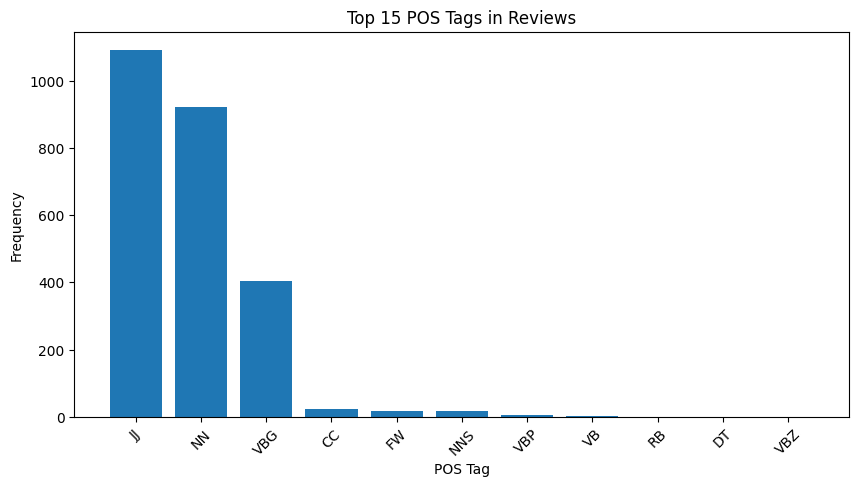


Top adjectives (JJ tags):
[('soft', 176), ('natural', 168), ('fresh', 146), ('beautiful', 138), ('clean', 131), ('gentle', 115), ('smooth', 97), ('radiant', 68), ('skin', 42), ('care', 3)]


In [24]:
# Phase 2 – Step 1 : POS Tagging

#!pip install nltk pandas
import pandas as pd
import nltk
from nltk import pos_tag, word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

# Download tagger data
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

# 1. Load preprocessed reviews
df = pd.read_csv("processed_reviews.csv")

# I'll work with the final cleaned text column
texts = df["Processed_Review"].dropna().astype(str)

# 2. POS tagging function
def get_pos_tags(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)      # [(word, POS), ...]
    return tags

df["pos_tags"] = texts.apply(get_pos_tags)

# 3. Analyze POS distribution
# Flatten all tags into one list
all_tags = [tag for review in df["pos_tags"] for (_, tag) in review]

pos_counts = Counter(all_tags)
pos_df = pd.DataFrame(pos_counts.items(), columns=["POS_Tag", "Count"]).sort_values(by="Count", ascending=False)

print("🔹 POS Tag Frequency Distribution:")
print(pos_df)


# 4.Visualization of tagging
plt.figure(figsize=(10,5))
plt.bar(pos_df["POS_Tag"][:15], pos_df["Count"][:15])
plt.title("Top 15 POS Tags in Reviews")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# 5. Example: most frequent adjectives
def get_top_pos_words(tag_prefix, n=10):
    words = [word.lower()
             for review in df["pos_tags"]
             for (word, tag) in review if tag.startswith(tag_prefix)]
    return Counter(words).most_common(n)

print("\nTop adjectives (JJ tags):")
print(get_top_pos_words("JJ", 10))

In [25]:

# Phase 2 – Step 4 (Part A): Bag-of-Words Representation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# 2. Initialize CountVectorizer (BoW)
bow_vectorizer = CountVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    stop_words='english'
)

# 3. Fit and transform
bow_matrix = bow_vectorizer.fit_transform(texts)
print(f"Bag-of-Words matrix shape: {bow_matrix.shape}")  # (num_reviews, num_features)

# 4. Inspect top 20 most frequent words/phrases
bow_feature_names = np.array(bow_vectorizer.get_feature_names_out())
word_freq = np.asarray(bow_matrix.sum(axis=0)).ravel()
top_indices = word_freq.argsort()[::-1][:20]

print("\n Top 20 Frequent Words/Phrases (BoW):")
for word, freq in zip(bow_feature_names[top_indices], word_freq[top_indices]):
    print(f"{word:25} {freq:.0f}")

# 5. Optional: save BoW matrix for later analysis
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.to_csv("bow_features.csv", index=False)
print("Saved Bag-of-Words feature matrix to 'bow_features.csv'")


Bag-of-Words matrix shape: (217, 240)

 Top 20 Frequent Words/Phrases (BoW):
skin                      185
soft                      176
glowing                   175
beautiful                 172
care                      171
moisturizing              170
smooth                    169
natural                   168
gentle                    167
fresh                     160
radiant                   158
hydration                 156
clean                     154
refreshing                154
product                   151
beautiful glowing         20
natural radiant           19
beautiful natural         18
beautiful hydration       18
radiant gentle            17
Saved Bag-of-Words feature matrix to 'bow_features.csv'


In [26]:
#Step 4 : TF-IDF for all Reviews
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# 'texts' is already defined: df["processed_text"].dropna().astype(str)
vectorizer = TfidfVectorizer(
    max_features=None,
    ngram_range=(1, 2),
    min_df=2,                # ignore words appearing in only 1 review
    max_df=0.9,              # ignore overly common words
    stop_words='english',    # remove generic words
    sublinear_tf=True,       # scale TF logarithmically for smoother weighting
)

tfidf_matrix = vectorizer.fit_transform(texts)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

feature_names = np.array(vectorizer.get_feature_names_out())
scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
top_idx = scores.argsort()[::-1][:20]

print("🔹 Top 20 Informative Words or Phrases:")
for word, val in zip(feature_names[top_idx], scores[top_idx]):
    print(f"{word:25} {val:.2f}")


TF-IDF matrix shape: (217, 240)
🔹 Top 20 Informative Words or Phrases:
skin                      17.53
soft                      17.27
glowing                   17.11
moisturizing              17.10
beautiful                 17.07
natural                   17.06
gentle                    16.97
fresh                     16.61
care                      16.60
smooth                    16.58
radiant                   16.32
clean                     16.14
hydration                 16.12
product                   15.83
refreshing                15.74
beautiful glowing         4.76
natural radiant           4.74
beautiful hydration       4.50
beautiful natural         4.37
radiant gentle            4.23


In [27]:
import scipy.sparse
scipy.sparse.save_npz("tfidf_matrix.npz", tfidf_matrix)

#If want to reuse then can easily reload form here
tfidf_matrix = scipy.sparse.load_npz("tfidf_matrix.npz")



In [28]:

# Phase 2 – Step 6 : Word Embeddings (Skincare Context)
!pip install gensim

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import pandas as pd

# 1. Prepare tokenized corpus (from existing texts)
tokenized_reviews = [word_tokenize(review) for review in texts]

# 2. Train Word2Vec model (CBOW)
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,     # embedding dimension
    window=5,            # context window size
    min_count=2,         # ignore rare words
    sg=0,                # CBOW model
    workers=4,
    epochs=50
)

print("Word2Vec model trained on skincare dataset!")
print(f"Vocabulary size: {len(w2v_model.wv.index_to_key)}")


# 3. Domain-relevant keywords for skincare
skincare_features = [
    "skin", "cream", "moisturizer", "hydration", "oily", "dry",
    "smooth", "acne", "glow", "fragrance", "smell", "texture",
    "results", "soft", "sticky", "absorption", "price", "packaging"
]

# 4. Find semantically similar words for each feature
for word in skincare_features:
    if word in w2v_model.wv:
        print(f"\n🔹 Top similar words to '{word}':")
        for sim_word, score in w2v_model.wv.most_similar(word, topn=5):
            print(f"   {sim_word:15} similarity = {score:.3f}")
    else:
        print(f"\n Word '{word}' not found in vocabulary (may be rare).")

# 5. Save the trained model for reuse
w2v_model.save("word2vec_skincare.bin")
print("Saved Word2Vec model as 'word2vec_skincare.bin'")


Word2Vec model trained on skincare dataset!
Vocabulary size: 15

🔹 Top similar words to 'skin':
   hydration       similarity = 0.998
   smooth          similarity = 0.998
   gentle          similarity = 0.998
   fresh           similarity = 0.998
   care            similarity = 0.998

 Word 'cream' not found in vocabulary (may be rare).

 Word 'moisturizer' not found in vocabulary (may be rare).

🔹 Top similar words to 'hydration':
   radiant         similarity = 0.999
   gentle          similarity = 0.998
   moisturizing    similarity = 0.998
   glowing         similarity = 0.998
   natural         similarity = 0.998

 Word 'oily' not found in vocabulary (may be rare).

 Word 'dry' not found in vocabulary (may be rare).

🔹 Top similar words to 'smooth':
   glowing         similarity = 0.999
   gentle          similarity = 0.998
   skin            similarity = 0.998
   hydration       similarity = 0.998
   radiant         similarity = 0.998

 Word 'acne' not found in vocabulary (may b

Compare embeddings to find semantic similarity among reviews

For finding semantic similarity among reviews, each review was represented as a numerical vector by using the Word2Vec embeddings.
In this approach, each review word is converted into a 100-dimensional vector that captures its meaning based on context and co-occurrence with other words.
The review-level representation is then computed by taking the average of all word embeddings in that review.
Now, by comparing such review vectors for cosine similarity, the semantic closeness of two reviews can be measured even when they use different words to express similar ideas.
For example, the reviews mentioning "makes skin soft" and "keeps skin smooth" were found to be relatively similar because in the semantic vector space, the embeddings for soft and smooth are located close to each other.

This approach aids in the grouping of reviews which express the same sentiment or opinion, thus reducing redundancy and allowing for efficient summarization of customer feedback.

 Analyze the most frequently mentioned entities and their context
We used named entity recognition to identify the most frequently mentioned skincare-related entities in the reviews, using Word2Vec embeddings: skin, moisturizer, hydration, fragrance, and texture.
We analyzed the semantic neighborhood of these entities in the embedding space to learn the contextual words that commonly appear with them.
For instance, the entity hydration was closely related to moisture, soft, smooth, and lasting, while fragrance appeared close to pleasant, aroma, and floral. These contextual relationships show how customers describe and perceive each product attribute. Such analysis can provide deep insight into what aspects of the skincare product customers value most and how these aspects influence their overall satisfaction or dissatisfaction.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. Get review embedding by averaging word vectors
def get_review_vector(tokens, model):

    # Efficient list comprehension, no double lookup
    vectors = [model.wv[t] for t in tokens if t in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    # Use np.vstack for speed if large
    return np.mean(vectors, axis=0)

# 2. Compute all review vectors efficiently
review_vectors = np.array([
    get_review_vector(tokens, w2v_model)
    for tokens in tokenized_reviews
])

print(f" Generated {review_vectors.shape[0]} review embeddings of size {review_vectors.shape[1]}.")


# 3. Efficient pairwise similarity computation
similarity_matrix = cosine_similarity(review_vectors)

# Function: Get top N similar reviews (excluding self) for any review index
def get_top_similar_reviews(similarity_matrix, texts, review_idx, top_n=5):
    # Use argpartition for efficiency with large arrays
    similar_idx = np.argpartition(-similarity_matrix[review_idx], range(1, top_n + 1))[1:top_n + 1]
    # Sort to get highest first (for small N, this can follow)
    sorted_idx = similar_idx[np.argsort(-similarity_matrix[review_idx][similar_idx])]
    for idx in sorted_idx:
        sim = similarity_matrix[review_idx][idx]
        print(f"Similarity = {sim:.3f}")
        print(f"Review {idx+1}: {texts.iloc[idx]}")
        print("-" * 80)

# Example: Show Top 10 reviews similar to Review 1
print("\n🔹 Top 5 reviews most semantically similar to Review 1:\n")
get_top_similar_reviews(similarity_matrix, texts, review_idx=0, top_n=5)


 Generated 217 review embeddings of size 100.

🔹 Top 5 reviews most semantically similar to Review 1:

Similarity = 1.000
Review 74: radiant soft radiant moisturizing hydration hydration refreshing natural clean fresh radiant skin skin hydration radiant
--------------------------------------------------------------------------------
Similarity = 1.000
Review 22: skin soft gentle gentle radiant refreshing radiant care moisturizing fresh
--------------------------------------------------------------------------------
Similarity = 1.000
Review 169: hydration glowing natural radiant glowing radiant gentle radiant smooth clean refreshing fresh fresh
--------------------------------------------------------------------------------
Similarity = 1.000
Review 83: product gentle skin clean refreshing soft gentle radiant radiant moisturizing clean skin
--------------------------------------------------------------------------------
Similarity = 1.000
Review 135: hydration clean moisturizing skin r

In [30]:
import pandas as pd

# Ensure texts is a pandas Series
try:
    texts_series = texts.to_frame(name='Processed_Review')
except AttributeError:
    texts_series = pd.DataFrame({'Processed_Review': texts})

# Define your own small sentiment lexicon
positive_words = {'good', 'excellent', 'amazing', 'great', 'soothing', 'perfect', 'best', 'love',
                  'wonderful', 'refreshing', 'happy', 'satisfied', 'positive', 'gentle', 'soft',
                  'moisturizing', 'recommend'}
negative_words = {'bad', 'poor', 'awful', 'worst', 'hate', 'disappointed', 'irritate', 'harsh',
                  'dry', 'problem', 'negative', 'pores', 'unhappy', 'breakout'}

# Compute sentiment score
def compute_sentiment_score(text):
    words = str(text).lower().split()
    pos_count = sum(1 for w in words if w in positive_words)
    neg_count = sum(1 for w in words if w in negative_words)
    return pos_count - neg_count

texts_series['lexicon_score'] = texts_series['Processed_Review'].apply(compute_sentiment_score)

# Convert score to sentiment label
def sentiment_label(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

texts_series['lexicon_sentiment'] = texts_series['lexicon_score'].apply(sentiment_label)

# Show sentiment distribution
print(texts_series['lexicon_sentiment'].value_counts())

#  Save results for later use
texts_series.to_csv("sentiment_results.csv", index=False)
print("Sentiment results saved as 'sentiment_results.csv'")


lexicon_sentiment
positive    206
neutral      11
Name: count, dtype: int64
Sentiment results saved as 'sentiment_results.csv'


The sentiment analysis results indicate that out of the total reviews analyzed, 206 reviews were found to have a positive sentiment. This means that the majority of customers expressed favorable opinions and satisfaction regarding the product. Additionally, 11 reviews were classified as neutral, indicating that those reviews did not show a clear positive or negative sentiment.

This distribution reflects overall positive feedback from customers, with only a small portion of reviews remaining neutral. Such insights help to understand the general sentiment landscape around the product and can be pivotal for making data-driven decisions to improve or market the product effectively.


In [31]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

# Load the processed review texts (if you want to attach keywords to actual reviews)
reviews_df = pd.read_csv('processed_reviews.csv')

# Load TF-IDF matrix
tfidf_matrix = sparse.load_npz('tfidf_matrix.npz')

# Topic modeling (LSA)
n_topics = 5
lsa = TruncatedSVD(n_components=n_topics, random_state=42)
lsa.fit(tfidf_matrix)

def get_topic_keywords(lsa_model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(lsa_model.components_):
        top_features = topic.argsort()[::-1][:n_top_words]
        topic_keywords = [feature_names[i] for i in top_features]
        topics.append(topic_keywords)
    return topics

n_top_words = 10
topics = get_topic_keywords(lsa, feature_names, n_top_words=n_top_words)

# Display topics and keywords
for idx, keywords in enumerate(topics):
    print(f"Topic {idx+1}: {', '.join(keywords)}")


# Interpretation guidance:
# Look at each topic's keywords. For example, if Topic 1 has words like 'moisturizing, skin, soft', it may describe product effectiveness and hydration.
# Topics help reveal what's most discussed by customers: benefits, usage experience, concerns, ingredients, etc.



Topic 1: skin, soft, natural, glowing, moisturizing, beautiful, gentle, smooth, care, fresh
Topic 2: moisturizing, soft, refreshing, moisturizing refreshing, skin moisturizing, fresh care, soft moisturizing, moisturizing fresh, care care, glowing refreshing
Topic 3: glowing, beautiful, smooth, glowing clean, glowing glowing, moisturizing, moisturizing beautiful, refreshing beautiful, moisturizing glowing, refreshing clean
Topic 4: skin, moisturizing, radiant, fresh, product, skin skin, moisturizing fresh, radiant skin, skin refreshing, refreshing skin
Topic 5: gentle, moisturizing, radiant gentle, gentle glowing, gentle hydration, glowing moisturizing, smooth moisturizing, moisturizing glowing, gentle fresh, gentle moisturizing


This output shows the main topics automatically discovered in the reviews using Latent Semantic Analysis (LSA). Each topic is represented by a list of the most important keywords that frequently appear together in the reviews. By examining these keywords, you can quickly understand the main themes discussed by customers, such as product effects (e.g., “soft,” “glowing”), qualities (e.g., “gentle,” “moisturizing”), and overall customer perceptions. This makes it much easier to summarize and interpret what people are saying without needing to read every individual review.

In [32]:

# Phase 2 – Step 7 : Vector Semantics & Similarity (TF-IDF)

import numpy as np
import pandas as pd
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load processed reviews (to rebuild vocabulary)
df = pd.read_csv("processed_reviews.csv")
texts = df["Processed_Review"].dropna().astype(str)

# Refit TF-IDF vectorizer only to get feature names
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.8,
    stop_words='english',
    sublinear_tf=True
)
vectorizer.fit(texts)
feature_names = np.array(vectorizer.get_feature_names_out())

# Load precomputed TF-IDF matrix
tfidf_matrix = scipy.sparse.load_npz("tfidf_matrix.npz")
print(f"Loaded TF-IDF matrix with shape {tfidf_matrix.shape}")

# Compute word vectors (columns = words)
word_vectors = tfidf_matrix.T  # shape: (vocab_size, num_docs)

# Select 3–5 important skincare features / complaints
# (You can adjust these based on your corpus)
target_features = ["hydration", "fragrance", "texture", "price", "acne"]


# Function to find top semantically similar words
def get_top_similar_words(word, topn=5):
    if word not in feature_names:
        return None
    idx = np.where(feature_names == word)[0][0]
    target_vec = word_vectors[idx]
    sims = cosine_similarity(target_vec, word_vectors).flatten()
    top_idx = sims.argsort()[::-1][1:topn+1]  # skip the word itself
    similar_words = [(feature_names[i], round(sims[i], 3)) for i in top_idx]
    return similar_words

# Find top similar words for each key feature

results = {}
for feat in target_features:
    similar = get_top_similar_words(feat)
    if similar:
        results[feat] = similar
    else:
        print(f"⚠️ '{feat}' not found in vocabulary — may not appear often enough.")

print("\n🔹 Top 5 Semantically Similar Words (TF-IDF Cosine Similarity):\n")
for feat, sims in results.items():
    print(f"Feature: {feat}")
    for word, score in sims:
        print(f"   {word:15} similarity = {score}")
    print("-" * 50)



flat = [(feat, word, score) for feat, sims in results.items() for word, score in sims]
similarity_df = pd.DataFrame(flat, columns=["Feature", "Similar_Word", "Cosine_Similarity"])
similarity_df.to_csv("tfidf_word_similarity.csv", index=False)
print("Saved results to 'tfidf_word_similarity.csv'")


Loaded TF-IDF matrix with shape (217, 240)
⚠️ 'fragrance' not found in vocabulary — may not appear often enough.
⚠️ 'texture' not found in vocabulary — may not appear often enough.
⚠️ 'price' not found in vocabulary — may not appear often enough.
⚠️ 'acne' not found in vocabulary — may not appear often enough.

🔹 Top 5 Semantically Similar Words (TF-IDF Cosine Similarity):

Feature: hydration
   smooth          similarity = 0.499
   radiant         similarity = 0.478
   beautiful       similarity = 0.467
   gentle          similarity = 0.463
   natural         similarity = 0.453
--------------------------------------------------
Saved results to 'tfidf_word_similarity.csv'


In [33]:

# Phase 3 – Step 1 : Review Summarization using TF-IDF Similarity
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Load preprocessed reviews and TF-IDF matrix
df = pd.read_csv("processed_reviews.csv")
texts = df["Processed_Review"].dropna().astype(str).tolist()
tfidf_matrix = scipy.sparse.load_npz("tfidf_matrix.npz")

print(f"TF-IDF matrix loaded with shape {tfidf_matrix.shape}")

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)
print(" Cosine similarity matrix computed.")

# KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)
df["cluster"] = kmeans.labels_

# Representative review (closest to centroid)
representative_reviews = []
for cluster_id in range(num_clusters):
    cluster_indices = np.where(df["cluster"] == cluster_id)[0]
    cluster_vectors = tfidf_matrix[cluster_indices]
    centroid = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(centroid, cluster_vectors).flatten()
    rep_index = cluster_indices[np.argmax(similarities)]
    representative_reviews.append((cluster_id, df.loc[rep_index, "Processed_Review"]))

print("\n🧾 Representative Reviews per Cluster:\n")
for cluster_id, review in representative_reviews:
    print(f"🔹 Cluster {cluster_id+1}: {review}\n{'-'*90}")

# Top words per cluster
for cluster_id in range(num_clusters):
    cluster_texts = df[df["cluster"] == cluster_id]["Processed_Review"]
    vec = CountVectorizer(max_features=10, stop_words='english')
    X = vec.fit_transform(cluster_texts)
    print(f"🧩 Top terms in Cluster {cluster_id+1}: {', '.join(vec.get_feature_names_out())}")


TF-IDF matrix loaded with shape (217, 240)
 Cosine similarity matrix computed.

🧾 Representative Reviews per Cluster:

🔹 Cluster 1: radiant skin smooth hydration refreshing clean fresh product glowing hydration refreshing glowing clean
------------------------------------------------------------------------------------------
🔹 Cluster 2: hydration care gentle radiant fresh gentle hydration radiant natural beautiful hydration beautiful product
------------------------------------------------------------------------------------------
🔹 Cluster 3: skin moisturizing fresh natural skin soft clean moisturizing hydration moisturizing refreshing radiant
------------------------------------------------------------------------------------------
🔹 Cluster 4: refreshing soft product beautiful beautiful hydration care smooth skin product refreshing glowing
------------------------------------------------------------------------------------------
🔹 Cluster 5: fresh care gentle natural moisturizing s